In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, Dense,Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tqdm import tqdm
from scipy.io import wavfile
# from google.colab import drive

2023-07-11 22:14:15.985590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 22:14:16.534783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def cut(arr, length):
  idx = len(arr)%length
  out = []
  while(idx+length <= len(arr)):
    out.append(arr[idx:idx+length])
    idx += length
  return np.array(out)

def loadSong(fName):
  fs, data = wavfile.read(inpathTrain + fName)
  if data.ndim > 1:
    mono_data = np.mean(data, axis=1)
  else:
    mono_data = data

  return mono_data.astype('int16')

def loadSongCut(fName):
  data = loadSong(fName)
  data = cut(data, snippitLength)
  scaler[fName] = MinMaxScaler()
  #data = quadratic_scaler(data, 5)
  data = scaler[fName].fit_transform(data)

  return train_test_split(data, test_size=0.3, random_state=42)

def digital_decibel(x):
  if (x>0):
    decibels = 1/ (10 * np.log10(x/1))
  else:
    decibels = 1 / (-1*  10 * np.log10(-x/1))
  return decibels

def quadratic_scaler(x, n):
  v = [i**n for i in x]
  return v

In [3]:
def snipLoss(y_true, y_pred):
  snipWeight = tf.convert_to_tensor([int(np.cosh(x)) for x in range(-5, 5, snippitLength)], dtype='float32')

  loss = math_ops.squared_difference(y_true,y_pred)
  loss = math_ops.Mul(x = loss,y = snipWeight)
  loss = math_ops.log1p(loss)
  return loss

def si_snr2(y_true, y_pred):
  # Remove extra dimensions
  y_true = tf.squeeze(y_true)
  y_pred = tf.squeeze(y_pred)

  # Compute the scaling factor
  scale = tf.reduce_sum(y_true * y_pred) / tf.reduce_sum(y_pred * y_pred)

  # Compute the estimated source and the target source
  est_source = scale * y_pred
  target_source = y_true

  # Compute the noise source
  noise_source = est_source - target_source

  # Compute the SI-SNR
  numerator = tf.reduce_sum(target_source * est_source, axis=-1)
  denominator = tf.reduce_sum(noise_source * noise_source, axis=-1)
  si_snr = 10 * tf.math.log(numerator / denominator + 1e-8) / tf.math.log(10.0)

  # Return the average SI-SNR
  return tf.reduce_mean(si_snr)

def si_snr(target, estimate):
  # target and estimate are tensors of shape (batch_size, time_steps)
  # compute the dot product of target and estimate along the time axis
  dot = tf.reduce_sum(target * estimate, axis=-1, keepdims=True)
  # compute the energy of target along the time axis
  energy = tf.reduce_sum(target ** 2, axis=-1, keepdims=True)
  # compute the scaled target
  scaled_target = dot * target / energy
  # compute the noise
  noise = estimate - scaled_target
  # compute the SI-SNR in decibels
  si_snr = 10 * tf.math.log(tf.reduce_sum(scaled_target ** 2, axis=-1) / tf.reduce_sum(noise ** 2, axis=-1)) / tf.math.log(10.0)
  # return the SI-SNR tensor of shape (batch_size,)
  return si_snr

In [4]:
# paths
# drive.mount('/content/drive')'
# inpathTrain = "/content/drive/MyDrive/Machine Learning/Autoencoder/train_data/"
# inpathOut = "/content/drive/MyDrive/Machine Learning/Autoencoder/output/"
# inpathTrain = "/home/martin/martin_user_data/jupyter_notebooks/autoencoder_ml/input/"
inpathTrain = "/mnt/e/data/SynologyDrive/Uni/mSem02/Machine Learning/Project_Audio_Autoencoder/musicnet_midis/BOT/Mixdown/output/"
inpathOut =   "/home/martin/martin_user_data/jupyter_notebooks/autoencoder_ml/output/"
fileNames = os.listdir(inpathTrain)
scaler = {}

# global variables
samplerate = 44_100
snippitLength = 50
snippitLength = 100 # 7,4
snippitLength = 128 # 7,4 GB 39s
snippitLength = 32  # 4,7 GB 110s
snippitLength = 64  # 2,8 Gb 60s

loss_fct = snipLoss
loss_fct = 'mse'

total_num_songs = len(fileNames)
TrainSongs = 0.25
numTrainSongs = int(total_num_songs*0.7*TrainSongs)
numTrainSongs = 1
numTestSongs = int(total_num_songs*0.3*TrainSongs)
numTestSongs = 1

# Hyperparameters
compression_ratio = 0.5
compression_ratio = 1
latentSize = int(compression_ratio*snippitLength)
# latentSize = 50
numDense = 3
numConvLayer = 2
numConv = 8

numDense = 3
numConvLayer = 2
numConv = 16


output_wav_name = f'snln={snippitLength}_cmpr={compression_ratio}_loss={loss_fct}_songs={numTrainSongs}'

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for i in physical_devices:
    tf.config.experimental.set_memory_growth(i, True)
tf.device('/device:GPU:0')

input = Input(shape=(snippitLength,1))
x = input

# Convolutional part of encoder
for i in range(numConvLayer):
  x = Conv1D(numConv, 5, activation='relu', padding='same')(x)
  x = MaxPooling1D(2, padding = 'same')(x)

convShape = x.shape
# calculate flatten dimension
flsize = 1
for i in x.shape:
  if(i != None):
    flsize*= i

x = Flatten()(x)
convShape2 = x.shape


# Dense part of encoder
denses = [int(i) for i in np.linspace(flsize, latentSize, numDense)]
for i in denses[1:]:
  x = Dense(i, activation='relu')(x)

encoded = x


# Dense part of decoder
x = encoded
for i in denses[::-1][1:]:
  if(numConvLayer == 0 and i == snippitLength):
    x = Dense(i, activation='sigmoid')(x)
  else:
    x = Dense(i, activation='relu')(x)

if(numConvLayer == 0):
  decoded = x

x = Reshape(convShape[1:])(x)

# Convolutional part of decoder
for i in range(numConvLayer):
  x = Conv1D(numConv,5, activation='relu', padding='same')(x)
  x = UpSampling1D(2)(x)
if(numConvLayer != 0):
  decoded = Conv1D(1,5, activation='sigmoid', padding='same')(x)

autoencoder = Model(input, decoded)
autoencoder.compile(optimizer='adam', loss=loss_fct, metrics=[si_snr])

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 64, 16)            96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 16)            1296      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0     

2023-07-11 22:14:17.784154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 22:14:17.801483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 22:14:17.801536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 22:14:17.802928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-11 22:14:17.803084: I tensorflow/compile

In [6]:
#numTrainSongs =
batch_size = 2**10
epochs = 5
histories = {}
numTrainSongs = 5
for fn in tqdm(fileNames[:numTrainSongs]):
  Xt, Xv = loadSongCut(fn)
  Xt = np.array(Xt)
  Xv = np.array(Xv)
  histories[fn] = autoencoder.fit(Xt, Xt,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(Xv, Xv))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


2023-07-11 22:14:21.640101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-11 22:14:22.291039: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x334f8880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-11 22:14:22.291080: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-07-11 22:14:22.295097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-11 22:14:22.317968: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:530] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/loca

188/188 [==============================] - 8s 15ms/step - loss: 0.0039 - si_snr: 23.6323 - val_loss: 7.8555e-04 - val_si_snr: 28.7430
Epoch 2/5
188/188 [==============================] - 2s 12ms/step - loss: 4.5396e-04 - si_snr: 30.8891 - val_loss: 2.9353e-04 - val_si_snr: 32.7275
Epoch 3/5
188/188 [==============================] - 2s 11ms/step - loss: 2.8082e-04 - si_snr: 33.1260 - val_loss: 1.9091e-04 - val_si_snr: 34.4898
Epoch 4/5
188/188 [==============================] - 2s 11ms/step - loss: 1.9815e-04 - si_snr: 34.7865 - val_loss: 1.5976e-04 - val_si_snr: 35.3762
Epoch 5/5
188/188 [==============================] - 2s 11ms/step - loss: 1.6988e-04 - si_snr: 35.4807 - val_loss: 2.9330e-04 - val_si_snr: 35.5501


 20%|██        | 1/5 [00:17<01:09, 17.37s/it]

Epoch 1/5
119/119 [==============================] - 2s 14ms/step - loss: 2.2751e-04 - si_snr: 34.4064 - val_loss: 1.7264e-04 - val_si_snr: 35.6998
Epoch 2/5
119/119 [==============================] - 1s 11ms/step - loss: 1.9395e-04 - si_snr: 35.3659 - val_loss: 1.8861e-04 - val_si_snr: 34.2715
Epoch 3/5
119/119 [==============================] - 1s 11ms/step - loss: 1.9313e-04 - si_snr: 35.3777 - val_loss: 1.5925e-04 - val_si_snr: 35.8785
Epoch 4/5
119/119 [==============================] - 1s 11ms/step - loss: 1.6447e-04 - si_snr: 36.0549 - val_loss: 2.2293e-04 - val_si_snr: 35.8335
Epoch 5/5
119/119 [==============================] - 1s 11ms/step - loss: 1.4683e-04 - si_snr: 36.8973 - val_loss: 1.2591e-04 - val_si_snr: 37.1960


 40%|████      | 2/5 [00:24<00:34, 11.45s/it]

Epoch 1/5
211/211 [==============================] - 3s 13ms/step - loss: 1.2025e-04 - si_snr: 37.0573 - val_loss: 9.1236e-05 - val_si_snr: 38.4999
Epoch 2/5
211/211 [==============================] - 2s 12ms/step - loss: 9.7905e-05 - si_snr: 38.5338 - val_loss: 1.0677e-04 - val_si_snr: 38.4013
Epoch 3/5
211/211 [==============================] - 2s 11ms/step - loss: 9.2138e-05 - si_snr: 38.8231 - val_loss: 1.4799e-04 - val_si_snr: 38.3804
Epoch 4/5
211/211 [==============================] - 2s 11ms/step - loss: 8.9896e-05 - si_snr: 39.0815 - val_loss: 7.3097e-05 - val_si_snr: 38.9019
Epoch 5/5
211/211 [==============================] - 2s 11ms/step - loss: 8.2324e-05 - si_snr: 39.4610 - val_loss: 6.7480e-05 - val_si_snr: 38.6917


 60%|██████    | 3/5 [00:37<00:24, 12.03s/it]

Epoch 1/5
182/182 [==============================] - 2s 13ms/step - loss: 1.1544e-04 - si_snr: 37.4724 - val_loss: 7.0514e-05 - val_si_snr: 39.1313
Epoch 2/5
182/182 [==============================] - 2s 12ms/step - loss: 8.0721e-05 - si_snr: 39.7243 - val_loss: 1.8738e-04 - val_si_snr: 39.0713
Epoch 3/5
182/182 [==============================] - 2s 11ms/step - loss: 8.1051e-05 - si_snr: 39.9724 - val_loss: 1.5672e-04 - val_si_snr: 38.8305
Epoch 4/5
182/182 [==============================] - 2s 11ms/step - loss: 6.8737e-05 - si_snr: 40.3834 - val_loss: 6.3102e-05 - val_si_snr: 40.2253
Epoch 5/5
182/182 [==============================] - 2s 12ms/step - loss: 7.9651e-05 - si_snr: 40.1074 - val_loss: 5.7021e-05 - val_si_snr: 41.2984


 80%|████████  | 4/5 [00:48<00:11, 11.66s/it]

Epoch 1/5
197/197 [==============================] - 3s 13ms/step - loss: 9.5763e-05 - si_snr: 39.0122 - val_loss: 8.4333e-05 - val_si_snr: 41.0103
Epoch 2/5
197/197 [==============================] - 2s 11ms/step - loss: 7.7306e-05 - si_snr: 41.7686 - val_loss: 7.9298e-05 - val_si_snr: 41.2857
Epoch 3/5
197/197 [==============================] - 2s 11ms/step - loss: 7.3142e-05 - si_snr: 42.4511 - val_loss: 2.3545e-04 - val_si_snr: 40.9466
Epoch 4/5
197/197 [==============================] - 2s 11ms/step - loss: 7.4604e-05 - si_snr: 42.1117 - val_loss: 8.7673e-05 - val_si_snr: 39.7521
Epoch 5/5
197/197 [==============================] - 2s 11ms/step - loss: 6.7799e-05 - si_snr: 42.6344 - val_loss: 6.1602e-05 - val_si_snr: 41.1073


100%|██████████| 5/5 [01:00<00:00, 12.09s/it]


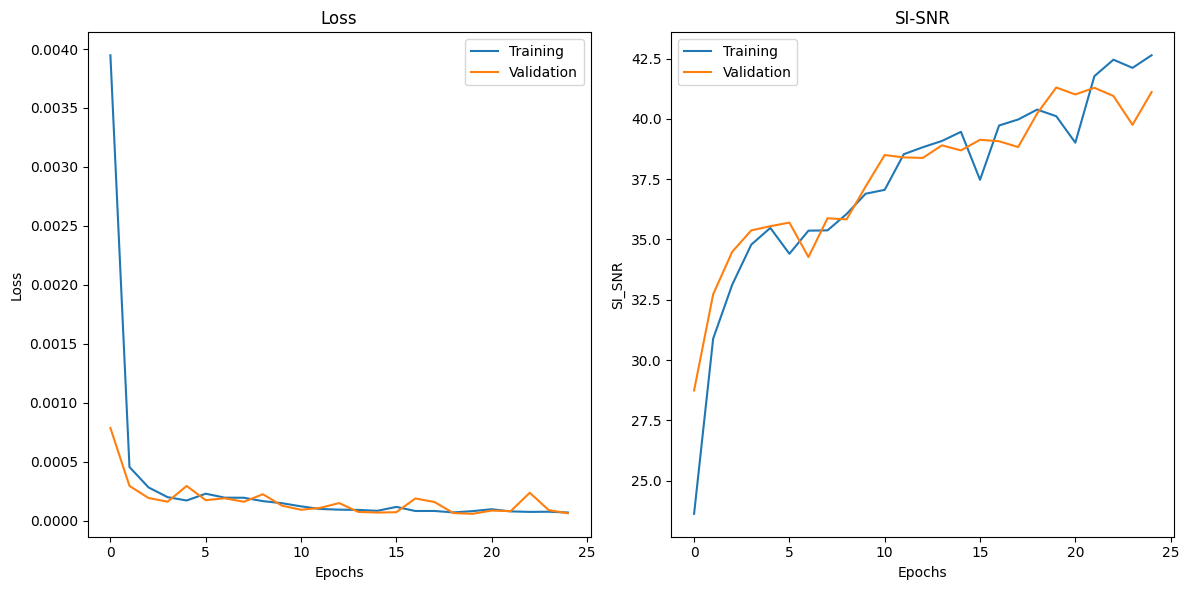

In [7]:
####################################
#####  plot history

def plot_loss(ax, network_history):
    loss = np.concatenate([network_history[key].history['loss'] for key in network_history.keys()])
    val_loss = np.concatenate([network_history[key].history['val_loss'] for key in network_history.keys()])

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(loss, label='Training')
    ax.plot(val_loss, label='Validation')
    ax.legend()

def plot_si_snr(ax, network_history):
    si_snr = np.concatenate([network_history[key].history['si_snr'] for key in network_history.keys()])
    val_si_snr = np.concatenate([network_history[key].history['val_si_snr'] for key in network_history.keys()])

    ax.set_xlabel('Epochs')
    ax.set_ylabel('SI_SNR')
    ax.set_title('SI-SNR')
    ax.plot(si_snr, label='Training')
    ax.plot(val_si_snr, label='Validation')
    ax.legend()

def plot_history(network_history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)

    plot_loss(ax[0], network_history)
    plot_si_snr(ax[1], network_history)

    plt.tight_layout()
    plt.show()


plot_history(histories)

In [8]:
####################################
#####  predict unknown song

exampleSong = fileNames[-1]
# exampleSong = '1727_schubert_op114_2.wav'
orig = loadSong(exampleSong)
origSnip = cut(orig, snippitLength)
orig = np.concatenate(origSnip)

if(exampleSong in scaler.keys()):
  scaler_Example = scaler[exampleSong]
  origSnip_transformed = scaler_Example.transform(origSnip)
else:
  scaler_Example = MinMaxScaler()
  origSnip_transformed = scaler_Example.fit_transform(origSnip)

# autoencode song
a = autoencoder.predict(origSnip_transformed)
a = a.reshape(-1, snippitLength)
XpredSnip = scaler_Example.inverse_transform(a)

silence = np.zeros((1,snippitLength), dtype = 'int16')
a = scaler_Example.transform(silence)
a = autoencoder.predict(a)
a = a.reshape(-1, snippitLength)
Xsilence = scaler_Example.inverse_transform(a)[0]

# remove noise generated by silence
XpredSnip = [i-Xsilence for i in XpredSnip]
Xpred = np.concatenate(XpredSnip).astype('int16')

test_loss, test_si_snr = autoencoder.evaluate(origSnip_transformed, origSnip_transformed)

output_wav_name += f'_SNR={test_si_snr:.1f}.wav'
wavfile.write(inpathOut + output_wav_name, samplerate, Xpred)
print(f"file saved: {output_wav_name}")


7877/7877 [==============================] - 32s 4ms/step - loss: 4.1082e-04 - si_snr: 28.7347
file saved: snln=64_cmpr=1_loss=mse_songs=1_SNR=28.7.wav


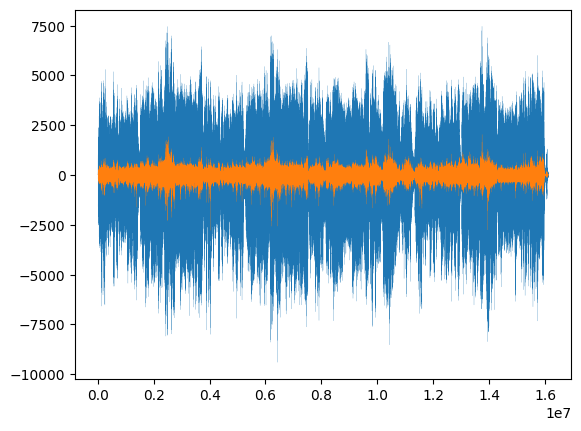

In [9]:
####################################
#####  see difference in waveform

plt.plot(orig, linewidth = 0.1)
plt.plot(orig-Xpred, linewidth = 0.1)

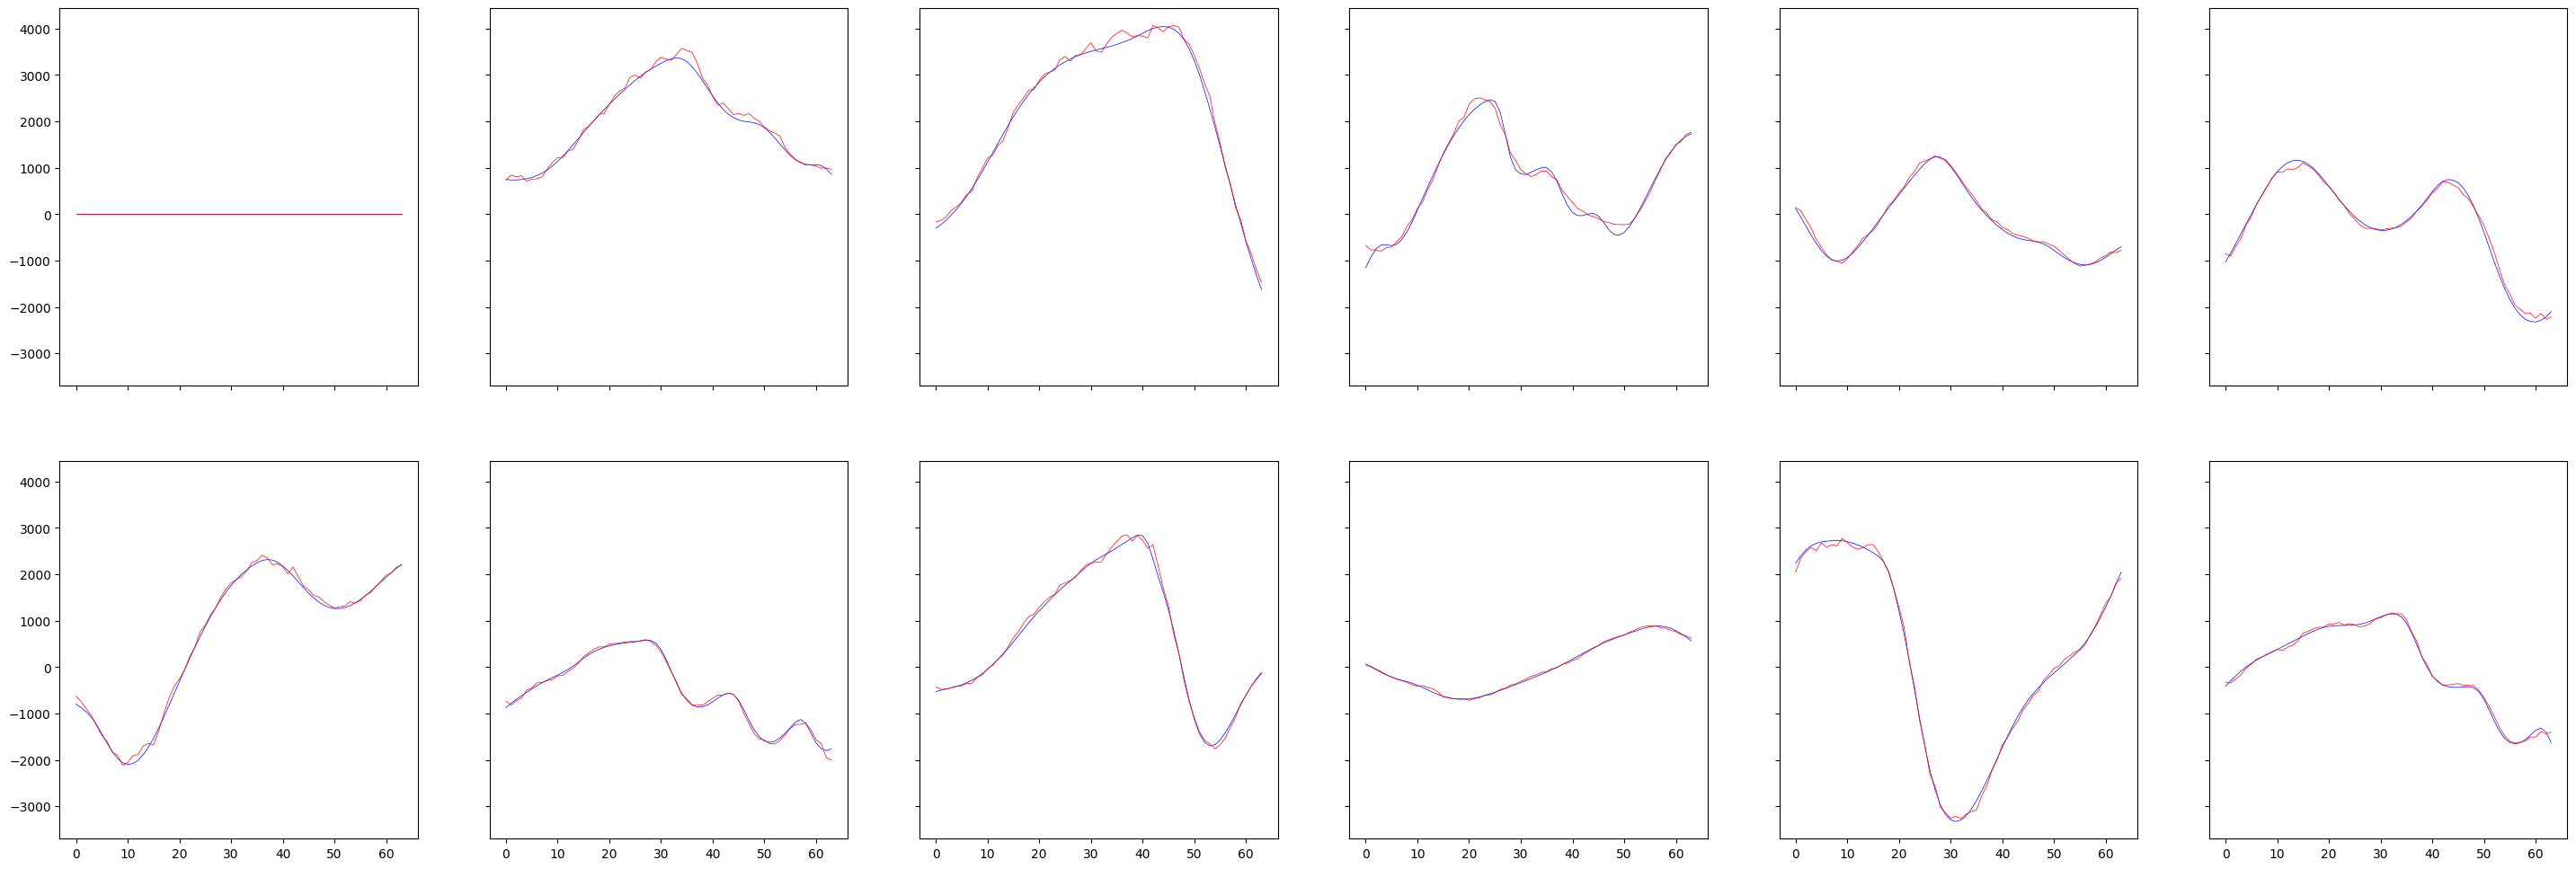

In [10]:
####################################
#####  see difference in waveform detailed

nrows = 2
ncols = 6
snips = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]

fig, ax = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows), sharey = True, sharex = True)
s = 0
for i in range(nrows):
  for j in range(ncols):
    ax[i][j].plot(origSnip[snips[s]], linewidth = 0.5, c = 'b')
    ax[i][j].plot(XpredSnip[snips[s]], linewidth = 0.5, c = 'r')
    s +=1

In [11]:
####################################
#####  evaluate test songs

# numTestSongs = 2
index = 0
test_evaluated = []
for songname in tqdm(reversed(fileNames[-numTestSongs:])):
    # songname = '1727_schubert_op114_2.wav'
    print(songname)
    song = loadSong(songname)
    # wavfile.write(inpathOut + songname + '.wav', samplerate, song)
    songSnip = cut(song, snippitLength)

    songSnip_transformed = MinMaxScaler().fit_transform(songSnip)
    test_loss, test_si_snr = autoencoder.evaluate(songSnip_transformed, songSnip_transformed, verbose=2)

    test_evaluated.append([songname, test_loss, test_si_snr])


# test_loss, test_si_snr = autoencoder.evaluate(songSnips_transformed, songSnips_transformed, verbose=2)
# print(test_evaluated)

0it [00:00, ?it/s]

2678_ps10_01.wav
7877/7877 - 29s - loss: 4.1082e-04 - si_snr: 28.7347 - 29s/epoch - 4ms/step


1it [00:29, 29.58s/it]
